In [ ]:
# Copyright (c) 2026 Nima Sharifinia
# Licensed under the Apache License, Version 2.0

In [1]:
# import kagglehub
# path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
# print("Path to dataset files:", path)
path = "/home/nima/Downloads/"

Imports

In [2]:
# !pip install torch_geometric

In [2]:
import json
import cv2
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import os
import sys
from torchvision import transforms
import re
from collections import Counter
import matplotlib.pyplot as plt

from torch_geometric.nn import GCNConv, GAT
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv  # Importing SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool

/home/nima/Nima/Project_img_cap_nima/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BATCH_SIZE = 256
feature_extraction_model = "xception"

Builiding vocab and tokenizer

In [4]:
class CustomTokenizer:
    def __init__(self, num_words=None, oov_token="<unk>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.max_length = 0
        self.word_to_idx = {}
        self.idx_to_word = {}

    def clean_text(self, text):
        # Convert to lowercase and remove punctuation (except spaces)
        text = text.lower()
        text = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~]', '', text)
        return text

    def fit_on_texts(self, texts):
        word_counts = {}

        # Split sentences into words correctly
        for text in texts:
            cleaned_text = self.clean_text(text)  # Proper cleaning
            words = cleaned_text.split()  # Split sentence into words
            if self.max_length < len(words):
              self.max_length = len(words)
            for word in words:
                word_counts[word] = word_counts.get(word, 0) + 1

        # Sort words by frequency
        sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

        # Limit vocab to num_words (excluding OOV)
        vocab_size = self.num_words - 1 if self.num_words else len(sorted_vocab)

        # Build the word_to_idx and idx_to_word dictionaries
        self.word_to_idx = {
            "<pad>": 0,
            "<unk>": 1,
        }
        self.idx_to_word = {
            0: "<pad>",
            1: "<unk>",
        }

        for idx, (word, _) in enumerate(sorted_vocab[:vocab_size], start=2):
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word

    def text_to_sequence(self, text):
        cleaned_text = self.clean_text(text)
        words = cleaned_text.split()  # Ensure proper tokenization
        return [self.word_to_idx.get(word, self.word_to_idx["<unk>"]) for word in words]  # Map to index


tokenizer = CustomTokenizer(num_words=5000, oov_token="<unk>")

COCO Dataset


In [6]:
class CocoDataSet(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.all_captions = []
        self.all_images = []
        self.all_ids = []
        self.max_length = 0
        self.PATH = f"{path}/coco2017/train2017/"

        # Load annotations
        with open(f'{path}/coco2017/annotations/captions_train2017.json', 'r') as file:
            data = json.load(file)

        # Create an image index
        image_id_index = {}
        for img in data['images']:
            image_id_index[img['id']] = img['file_name']

        for annot in data['annotations']:
            caption = '<start> ' + annot['caption'] + ' <end>'
            image_id = annot['image_id']
            if not image_id in self.all_ids:
                full_coco_image_path = self.PATH + image_id_index[image_id]
                self.all_ids.append(image_id)
                self.all_images.append(full_coco_image_path)
                self.all_captions.append(caption)

    def encode(self, caption):
        caption = tokenizer.clean_text(caption)
        encoded_caption = tokenizer.text_to_sequence(caption)
        remain = tokenizer.max_length - len(encoded_caption)
        for i in range(remain):
            encoded_caption.append(0)

        return torch.tensor(encoded_caption)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.all_captions)

    def __getitem__(self, idx):
        """Fetches the image and encoded caption at the specified index."""
        image_name = self.all_images[idx]

        img_features = np.load(image_name + "_" + feature_extraction_model + '.npy')
        reltr_features = np.load(image_name + "_reltr.npy")

        # image = Image.open(image_name)
        # if self.transform:
        #     image = self.transform(image)


        # Get the corresponding caption
        caption = self.all_captions[idx]

        # One-hot encode the caption
        encoded_caption = self.encode(caption)

        return img_features, reltr_features, caption, encoded_caption

# Example usage
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure 3 channels (convert grayscale to RGB)
    transforms.ToTensor(),
])

# Create the custom dataset
dataset = CocoDataSet(transform=transform)
dataset_len = len(dataset)

tokenizer = CustomTokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(dataset.all_captions)

In [7]:
class CocoValDataSet(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.all_captions = []
        self.all_images = []
        self.all_ids = []
        self.max_length = 0
        self.PATH = f"{path}/coco2017/val2017/"

        # Load annotations
        with open(f'{path}/coco2017/annotations/captions_val2017.json', 'r') as file:
            data = json.load(file)

        # Create an image index
        image_id_index = {}
        for img in data['images']:
            image_id_index[img['id']] = img['file_name']

        for annot in data['annotations']:
            caption = '<start> ' + annot['caption'] + ' <end>'
            image_id = annot['image_id']
            if not image_id in self.all_ids:
              full_coco_image_path = self.PATH + image_id_index[image_id]
              self.all_ids.append(image_id)
              self.all_images.append(full_coco_image_path)
              self.all_captions.append(caption)

    def encode(self, caption):
        caption = tokenizer.clean_text(caption)
        encoded_caption = tokenizer.text_to_sequence(caption)
        remain = tokenizer.max_length - len(encoded_caption)
        for i in range(remain):
            encoded_caption.append(0)

        return torch.tensor(encoded_caption)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.all_captions)

    def __getitem__(self, idx):
        """Fetches the image and one-hot encoded caption at the specified index."""
        image_name = self.all_images[idx]

        # Load image features
        img_features = np.load(image_name + "_" + feature_extraction_model + '.npy')
        reltr_features = np.load(image_name + "_reltr.npy")

        # Get the corresponding caption
        caption = self.all_captions[idx]

        # One-hot encode the caption
        encoded_caption = self.encode(caption)

        return image_name, img_features, reltr_features, encoded_caption

val_dataset = CocoValDataSet(transform=transform)
val_dataset_len = len(val_dataset)

Dataloader

In [8]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Encoder and Decoder

In [10]:
class BahdanauAttention(nn.Module):

    def __init__(self, embedding_dim, units):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.embedding_dim = embedding_dim
        self.W1 = nn.Linear(self.embedding_dim, self.units).to(device)
        self.W2 = nn.Linear(self.units, self.units).to(device)
        self.V = nn.Linear(self.units, 1).to(device)

    def forward(self, features, hidden):
        # features (CNN_encoder output) shape == (batch_size, 100, embedding_dim)
        # hidden shape == (1, batch_size, hidden_size)

        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        # hidden_with_time_axis = hidden.unsqueeze(1)
        hidden_with_time_axis = hidden.permute(1, 0, 2)

        # score shape == (batch_size, features, hidden_size)
        score = torch.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, features, 1)
        attention_weights = torch.softmax(self.V(score), dim=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = context_vector.sum(dim=1)

        return context_vector, attention_weights


class CNN_Encoder(nn.Module):
    # This encoder passes features through a Fully Connected layer
    def __init__(self, input_dim, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, embedding_dim).to(device)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        return x


class RNN_Decoder(nn.Module):

    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.vocab_size = vocab_size

        # Define layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.gru = nn.GRU(units, units, batch_first=True).to(device)
        self.fc1 = nn.Linear(self.units, self.units).to(device)
        self.fc2 = nn.Linear(self.units, self.vocab_size).to(device)

        # Attention mechanism
        self.attention = BahdanauAttention(embedding_dim, units)

    def forward(self, x, features, hidden):
        # Attention: Compute context_vector and attention_weights
        context_vector, attention_weights = self.attention(features, hidden)


        # x shape after embedding: (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # Concatenate context_vector with embedded input (context_vector Shape: (batch_size, 1, units))
        # x shape after concatenation: (batch_size, 1, units)
        x = torch.cat([context_vector.unsqueeze(1), x], dim=-1)

        # Passing the concatenated vector to the GRU
        output, state = self.gru(x, hidden)

        # Passing GRU output to the first fully connected layer
        # output shape: (batch_size, seq_length, units)
        # x shape after fc1: (batch_size, 1, units)
        x = self.fc1(output)

        # Reshape x to prepare for the final fully connected layer
        x = x.view(-1, x.size(2))  # (batch_size * seq_length, units)

        # Final fully connected layer
        x = self.fc2(x)  # (batch_size * seq_length, vocab_size)

        return x, state, attention_weights

    def reset_state(self, batch_size, device):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.units).to(device)



Reltr

In [11]:
CLASSES = [ 'NA', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
                'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
                'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
                'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
                'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
                'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
                'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
                'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
                'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
                'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
                'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
                'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
                'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
                'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra']

REL_CLASSES = ['background', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
                'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
                'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
                'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
                'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
                'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']


from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.reltr import RelTR

position_embedding = PositionEmbeddingSine(128, normalize=True)
backbone = Backbone('resnet50', False, False, False)
backbone = Joiner(backbone, position_embedding)
backbone.num_channels = 2048

transformer = Transformer(d_model=256, dropout=0.1, nhead=8,
                          dim_feedforward=2048,
                          num_encoder_layers=6,
                          num_decoder_layers=6,
                          normalize_before=False,
                          return_intermediate_dec=True)

rel_tr_model = RelTR(backbone, transformer, num_classes=151, num_rel_classes = 51,
              num_entities=100, num_triplets=200)



# The checkpoint is pretrained on Visual Genome
ckpt = torch.load(
    'checkpoint_reltr.pth',
    map_location=device,
    weights_only=False)

for param in rel_tr_model.parameters():
    param.requires_grad = False

reltr_model = rel_tr_model.to(device)
reltr_model.load_state_dict(ckpt['model'])
reltr_model.eval()

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
          (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

/home/nima/Nima/Project_img_cap_nima/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nima/Nima/Project_img_cap_nima/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
coded_classes = []
coded_rels = []

for cls in CLASSES:
    cleaned_cls = tokenizer.clean_text(cls)
    words = cleaned_cls.split(" ")
    coded_words = []
    for w in words:
      coded_words.append(tokenizer.word_to_idx.get(w, tokenizer.word_to_idx["<unk>"]))
    coded_classes.append(coded_words)

max_len = 0
for cls in REL_CLASSES:
    cleaned_cls = tokenizer.clean_text(cls)
    words = cleaned_cls.split(" ")
    coded_words = []
    for w in words:
      coded_words.append(tokenizer.word_to_idx.get(w, tokenizer.word_to_idx["<unk>"]))
    coded_rels.append(coded_words)
    if len(words) > max_len:
      max_len = len(words)

# Max length of rel classes = max_len
# Now make the length of rel classes same as max_len (padding)
padded_tensors = []
for t in coded_rels:
    # اگر طول تنسور کمتر از max_len است، آن را با صفر پد می‌کنیم
    padding = max_len - len(t)
    for i in range(padding):
        t.append(0)
    padded_tensors.append(t)

padded_tensors = torch.tensor(padded_tensors)
coded_classes = torch.tensor(coded_classes)
coded_rels = torch.tensor(padded_tensors)

/tmp/ipykernel_131376/256177945.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coded_rels = torch.tensor(padded_tensors)


Modified Reltr

In [13]:
transform_reltr = transforms.Compose([
    transforms.Resize(800),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_toTensor = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
])

class ModifiedReltr(torch.nn.Module):
  def __init__(self):
      super().__init__()
      self.rel_tr_model = rel_tr_model.to(device)
      self.rel_tr_model.load_state_dict(ckpt['model'])
      self.rel_tr_model.eval()

  def forward(self, x):
    outputs_all = []
    for im in x:
      img = transform_reltr(im).unsqueeze(0)
      # propagate through the model
      outputs = rel_tr_model(img)
      # keep only predictions with >0.3 confidence
      probas = outputs['rel_logits'].softmax(-1)[0, :, :-1]
      probas_sub = outputs['sub_logits'].softmax(-1)[0, :, :-1]
      probas_obj = outputs['obj_logits'].softmax(-1)[0, :, :-1]
      keep = torch.logical_and(probas.max(-1).values > 0.3, torch.logical_and(probas_sub.max(-1).values > 0.3,
                                                                              probas_obj.max(-1).values > 0.3))
      filtered_probas = probas[keep]
      filtered_probas_sub = probas_sub[keep]
      filtered_probas_obj = probas_obj[keep]

      nodes = []
      node_ids = []
      # return nodes
      edges = [[],[]]
      edge_attr = []
      for idx, _ in enumerate(filtered_probas):
        obj = coded_classes[filtered_probas_obj[idx].argmax()]
        obj_id = filtered_probas_obj[idx].argmax()
        if not obj_id in node_ids:
          nodes.append(obj)
          node_ids.append(obj_id)
        sub = coded_classes[filtered_probas_sub[idx].argmax()]
        sub_id = filtered_probas_sub[idx].argmax()
        if not sub_id in node_ids:
          nodes.append(sub)
          node_ids.append(sub_id)


        # print(CLASSES[filtered_probas_obj[idx].argmax()])
        idx_obj = node_ids.index(filtered_probas_obj[idx].argmax())
        idx_sub = node_ids.index(filtered_probas_sub[idx].argmax())
        edges[0].append(idx_sub)
        edges[1].append(idx_obj)
        edge_attr.append(padded_tensors[filtered_probas[idx].argmax()])

      if (len(nodes)>0):
        np_array1 = torch.stack(nodes)
        np_array1 = np_array1.to(device,dtype=torch.float)
        # print(np_array1.shape)
        x_np1 = np_array1.reshape((np_array1.shape[0],1))
      else :
        x_np1 = torch.tensor([[]]).to(device)
      edges_new = [torch.from_numpy(np.array(e)) for e in edges]
      np_array2 = torch.stack(edges_new)
      x_np2 = np_array2.to(device,dtype=int)



      if (len(nodes)>0):
        x_np3 = torch.stack(edge_attr).to(device)
      else :
        x_np3 = torch.tensor([]).to(device)


      graph_data = Data(x=x_np1, edge_index=x_np2,edge_attr=x_np3)
      outputs_all.append(graph_data)


    return outputs_all

# Test
# modified_reltr = ModifiedReltr()
# image_name1, img_features, encoded_caption = val_dataset[0]
# image_name2, img_features, encoded_caption = val_dataset[1]
# im = [transform_toTensor(Image.open(image_name1)),transform_toTensor(Image.open(image_name2))]
# tst = torch.stack(im).to(device)
# graph_data = modified_reltr(tst)
# print(graph_data[0].x)

GCN

In [14]:
class MainGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MainGCN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)  # Using GraphConv
        self.conv2 = GraphConv(hidden_dim, output_dim)  # Using GraphConv
        self.fc = nn.Linear(output_dim, 2048)

    def forward(self, ls):
      out = []
      for g in ls:
        # print(g)
        x , edge_index , edge_attr = g.x , g.edge_index,g.edge_attr
        if(x.size()==(1, 0)):
          out.append(torch.zeros((1,2048)).to(device))
          continue
        # x = self.conv1(x, edge_index,edge_attr)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = self.conv2(x, edge_index,edge_attr)
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, g.batch)

        x = self.fc(x)

        out.append(x)
      return torch.stack(out)


# gcn_model = MainGCN(input_dim=-1, hidden_dim=4, output_dim=128)
# gcn_model = gcn_model.to(device)

# embedding = gcn_model(graph_data)
# print("Graph Embedding:")
# print(embedding.shape)

GAT

In [15]:
class MainGAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4):
        super(MainGAT, self).__init__()
        self.att1 = GAT(input_dim, hidden_dim,num_layers)  # Using GraphConv
        self.att2 = GAT(hidden_dim, output_dim,num_layers)  # Using GraphConv
        self.fc = nn.Linear(output_dim, 2048)

    def forward(self, ls):
      out = []
      for g in ls:
        # print(g)
        x , edge_index , edge_attr = g.x , g.edge_index,g.edge_attr
        if(x.size()==(1, 0)):
          out.append(torch.zeros((1,2048)).to(device))
          continue
        # x = self.conv1(x, edge_index,edge_attr)
        x = self.att1(x, edge_index,edge_attr=edge_attr)
        x = F.relu(x)
        # x = self.conv2(x, edge_index,edge_attr)
        x = self.att2(x, edge_index,edge_attr=edge_attr)

        x = global_mean_pool(x, g.batch)

        x = self.fc(x)

        out.append(x)
      return torch.stack(out)

# relTR_model = ModifiedReltr().to(device)
# graph_encoder = MainGAT(input_dim=-1, hidden_dim=4, output_dim=2048).to(device)

# img_name, img_tensor = dataset[0]
# print(img_name)
# print(img_tensor.shape)

In [16]:
# !pip install ultralytics

Hyper Parameters

In [22]:
from ultralytics import YOLO


MY_EMBEDDING_DIM = 256
UNIT_COUNT = 512
EPOCH_COUNT = 20
yolo_model = YOLO("yolo11n.pt")
vocab_size = 5000 + 1
ENCODER_DIM = 2048
NUM_STEPS = dataset_len // BATCH_SIZE
NUM_STEPS_VAL = val_dataset_len // BATCH_SIZE
# NUM_STEPS = len(dataloader)
# NUM_STEPS_VAL = len(val_dataloader)

# image_model = timm.create_model(feature_extraction_model, pretrained=True, num_classes=0, global_pool='')
encoder = CNN_Encoder(ENCODER_DIM, MY_EMBEDDING_DIM)
decoder = RNN_Decoder(MY_EMBEDDING_DIM, UNIT_COUNT, vocab_size)
# relTR_model = ModifiedReltr().to(device)
# graph_encoder = MainGCN(input_dim=-1, hidden_dim=4, output_dim=2048).to(device)

# image_model = image_model.to(device)
encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=0.001
)

loss_object = nn.CrossEntropyLoss(reduction='none')

def loss_function(real, pred):
    real = real.to(device)
    pred = pred.to(device)

    # Create a mask where real != 0
    mask = real != 0

    # Compute the loss
    loss_ = loss_object(pred, real)

    # Cast the mask to the same data type as the loss
    # mask = mask.any(dim=1).type_as(loss_)  # mask now has shape [64]
    mask = mask.type_as(loss_)

    # Apply the mask to the loss
    loss_ *= mask

    # Return the mean loss
    return loss_.mean()

def train_step(img_features, reltr_features, target):
    loss = 0

    # Initialize the hidden state for each batch
    hidden = decoder.reset_state(batch_size=target.shape[0], device=device)

    # Initialize the decoder input with <start> token
    dec_input = torch.tensor([tokenizer.word_to_idx['<start>']] * target.shape[0], dtype=torch.long).unsqueeze(1).to(device)

    # Enable gradient calculation
    optimizer.zero_grad()

    img_features = img_features.to(device)
    reltr_features = reltr_features.to(device)
    features = torch.cat((img_features, reltr_features.squeeze(1)), dim=1)
    features = encoder(features)
    
    # Iterate over the caption length (time steps)
    for i in range(1, target.shape[1]):
        # Pass features and decoder input through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        # Compute loss for the current time step
        loss += loss_function(target[:, i], predictions)
        # loss += loss_object(predictions, target[:, i])

        # Use teacher forcing: Set the decoder input to the current target token
        dec_input = target[:, i].unsqueeze(1).to(device)

    # Normalize the loss by the sequence length
    total_loss = loss / target.shape[1]

    # Compute gradients and perform optimizer step
    loss.backward()
    optimizer.step()

    return loss.item(), total_loss.item()

def evaluate_step(img_features, reltr_features, target):
    loss = 0

    with torch.no_grad():
        hidden = decoder.reset_state(batch_size=target.shape[0], device=device)
        dec_input = torch.tensor([tokenizer.word_to_idx['<start>']] * target.shape[0], dtype=torch.long).unsqueeze(1).to(device)

        img_features = img_features.to(device)
        reltr_features = reltr_features.to(device)
        features = torch.cat((img_features, reltr_features.squeeze(1)), dim=1)
        features = encoder(features)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = target[:, i].unsqueeze(1).to(device)

    total_loss = loss / target.shape[1]
    return loss.item(), total_loss.item()


In [12]:
dataset = None

In [13]:
import logging
# logging.basicConfig(level=logging.WARNING)
logging.getLogger('ultralytics').setLevel(logging.WARNING)

In [23]:
loss_plot = []
val_loss_plot = []

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

# Paths to save best models
encoder_path = 'best_encoder.pth'
decoder_path = 'best_decoder.pth'

for epoch in range(EPOCH_COUNT):
    total_loss = 0

    encoder.train()
    decoder.train()

    for batch, (img_features, reltr_features, caption, encoded_caption) in enumerate(dataloader):
        batch_loss, t_loss = train_step(img_features, reltr_features, encoded_caption)
        total_loss += t_loss

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss / int(encoded_caption.shape[1])))

    loss_plot.append(total_loss / NUM_STEPS)

    # Validation
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    for (val_img_name, val_img_features, val_reltr_features, target) in val_dataloader:
        val_batch_loss, val_loss = evaluate_step(val_img_features, val_reltr_features, target)
        total_val_loss += val_loss
    val_loss_plot.append(total_val_loss / NUM_STEPS_VAL)

    print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / NUM_STEPS))
    print('Epoch {} Validation Loss {:.6f}'.format(epoch + 1, total_val_loss / NUM_STEPS_VAL))

    # Early stopping and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0

        # Save the best model weights
        torch.save(encoder, encoder_path)
        torch.save(decoder, decoder_path)
        print(f"Model saved at epoch {epoch + 1}")
    # else:
    #     epochs_without_improvement += 1
    #     if epochs_without_improvement >= patience:
    #         print(f"Early stopping at epoch {epoch + 1}")
    #         break


Epoch 1 Batch 0 Loss 1.9012
Epoch 1 Batch 50 Loss 1.0447
Epoch 1 Batch 100 Loss 0.8472
Epoch 1 Batch 150 Loss 0.7634
Epoch 1 Batch 200 Loss 0.7385
Epoch 1 Batch 250 Loss 0.6887
Epoch 1 Batch 300 Loss 0.6451
Epoch 1 Batch 350 Loss 0.6434
Epoch 1 Batch 400 Loss 0.6038
Epoch 1 Batch 450 Loss 0.6022
Epoch 1 Loss 0.764277
Epoch 1 Validation Loss 0.597475
Model saved at epoch 1
Epoch 2 Batch 0 Loss 0.5726
Epoch 2 Batch 50 Loss 0.5954
Epoch 2 Batch 100 Loss 0.5682
Epoch 2 Batch 150 Loss 0.5530
Epoch 2 Batch 200 Loss 0.5883
Epoch 2 Batch 250 Loss 0.5637
Epoch 2 Batch 300 Loss 0.5518
Epoch 2 Batch 350 Loss 0.5320
Epoch 2 Batch 400 Loss 0.5470
Epoch 2 Batch 450 Loss 0.5510
Epoch 2 Loss 0.563713
Epoch 2 Validation Loss 0.550615
Model saved at epoch 2
Epoch 3 Batch 0 Loss 0.5066
Epoch 3 Batch 50 Loss 0.5369
Epoch 3 Batch 100 Loss 0.5043
Epoch 3 Batch 150 Loss 0.5124
Epoch 3 Batch 200 Loss 0.5350
Epoch 3 Batch 250 Loss 0.5331
Epoch 3 Batch 300 Loss 0.5408
Epoch 3 Batch 350 Loss 0.4930
Epoch 3 Batch

In [21]:
# torch.save(encoder, "encoder.pth")
# torch.save(decoder, "decoder.pth")

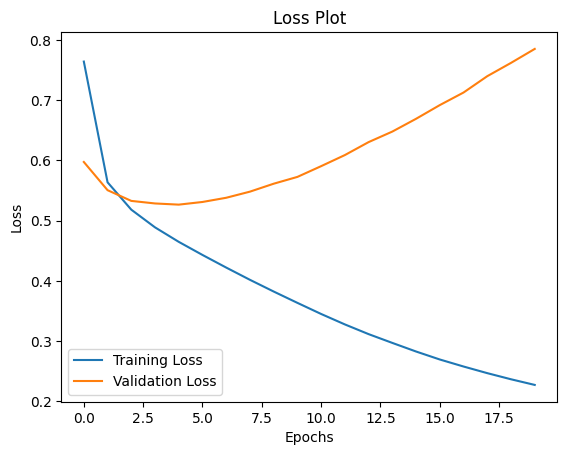

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(loss_plot, label='Training Loss')
plt.plot(val_loss_plot, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [26]:
# encoder = torch.load("encoder_xception-v2.pth", map_location=device)
# decoder = torch.load("decoder_xception-v2.pth", map_location=device)
encoder.eval()
decoder.eval()

RNN_Decoder(
  (embedding): Embedding(5001, 256)
  (gru): GRU(512, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5001, bias=True)
  (attention): BahdanauAttention(
    (W1): Linear(in_features=256, out_features=512, bias=True)
    (W2): Linear(in_features=512, out_features=512, bias=True)
    (V): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [27]:
def evaluate(img_features, reltr_features):
    attention_plot = np.zeros((tokenizer.max_length, 102))

    hidden = decoder.reset_state(batch_size=1, device=device)


    img_features = img_features.to(device)
    reltr_features = reltr_features.to(device)


    features = torch.cat((img_features, reltr_features.squeeze(0)), dim=0)
    features = encoder(features)

    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    dec_input = torch.tensor([tokenizer.word_to_idx['<start>']], dtype=torch.long).unsqueeze(1).to(device)


    result = []

    for i in range(tokenizer.max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = attention_weights.view(-1).cpu().detach().numpy()

        # predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_id = torch.multinomial(torch.nn.functional.softmax(predictions, dim=-1), 1).item()
        # predicted_id = torch.argmax(predictions, dim=-1).item()
        result.append(tokenizer.idx_to_word[predicted_id])

        if tokenizer.idx_to_word[predicted_id] == '<end>':
            return result, attention_plot

        # dec_input = tf.expand_dims([predicted_id], 0)
        dec_input = torch.tensor([predicted_id]).unsqueeze(0).to(device)

    return result, attention_plot

In [25]:
# !pip install nltk rouge-score pycocoevalcap

In [28]:
total = len(val_dataset)
file = open("results.json", "a")  # append mode
file.write("[")
for i, (img_name, img_features, reltr_features, encoded_caption) in enumerate(val_dataset):
  generated_caption, attention_plot = evaluate(torch.tensor(img_features), torch.tensor(reltr_features))
  obj = {"image_id": val_dataset.all_ids[i], "caption": ' '.join(generated_caption)}
  file.write(json.dumps(obj))
  if i + 1 != total:
    file.write(",")
  print(f"{i+1}/{total}")
file.write("]")
file.close()

1/5000
2/5000
3/5000
4/5000
5/5000
6/5000
7/5000
8/5000
9/5000
10/5000
11/5000
12/5000
13/5000
14/5000
15/5000
16/5000
17/5000
18/5000
19/5000
20/5000
21/5000
22/5000
23/5000
24/5000
25/5000
26/5000
27/5000
28/5000
29/5000
30/5000
31/5000
32/5000
33/5000
34/5000
35/5000
36/5000
37/5000
38/5000
39/5000
40/5000
41/5000
42/5000
43/5000
44/5000
45/5000
46/5000
47/5000
48/5000
49/5000
50/5000
51/5000
52/5000
53/5000
54/5000
55/5000
56/5000
57/5000
58/5000
59/5000
60/5000
61/5000
62/5000
63/5000
64/5000
65/5000
66/5000
67/5000
68/5000
69/5000
70/5000
71/5000
72/5000
73/5000
74/5000
75/5000
76/5000
77/5000
78/5000
79/5000
80/5000
81/5000
82/5000
83/5000
84/5000
85/5000
86/5000
87/5000
88/5000
89/5000
90/5000
91/5000
92/5000
93/5000
94/5000
95/5000
96/5000
97/5000
98/5000
99/5000
100/5000
101/5000
102/5000
103/5000
104/5000
105/5000
106/5000
107/5000
108/5000
109/5000
110/5000
111/5000
112/5000
113/5000
114/5000
115/5000
116/5000
117/5000
118/5000
119/5000
120/5000
121/5000
122/5000
123/5000
1

In [30]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

annotation_file = f'{path}/coco2017/annotations/captions_val2017.json'
# results_file = 'captions_val2017_fakecap_results.json'

# annotation_file = '/content/drive/MyDrive/captions_val2017.json'
results_file = './results.json'

# create coco object and coco_result object
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco, coco_result)

# evaluate on a subset of images by setting
# coco_eval.params['image_id'] = coco_result.getImgIds()
# please remove this line when evaluating the full validation set
# coco_eval.params['image_id'] = coco_result.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 307315 tokens at 4063324.10 tokens per second.
PTBTokenizer tokenized 62976 tokens at 1332784.02 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 57977, 'reflen': 54070, 'guess': [57977, 52977, 47977, 42977], 'correct': [26391, 8833, 2845, 965]}
ratio: 1.0722581838357488
Bleu_1: 0.455
Bleu_2: 0.275
Bleu_3: 0.165
Bleu_4: 0.100
computing METEOR score...
METEOR: 0.160
computing Rouge score...
ROUGE_L: 0.359
computing CIDEr score...
CIDEr: 0.328
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.1 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.2

SPICE evaluation took: 16.40 s
SPICE: 0.086
Bleu_1: 0.455
Bleu_2: 0.275
Bleu_3: 0.165
Bleu_4: 0.100
METEOR: 0.160
ROUGE_L: 0.359
CIDEr: 0.328
SPICE: 0.086


a motorcycle parked next to a red car <end>


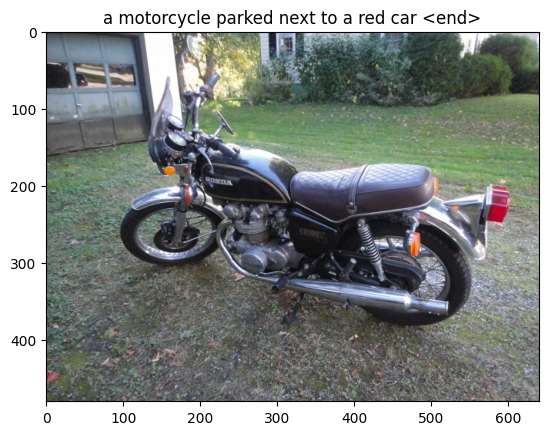

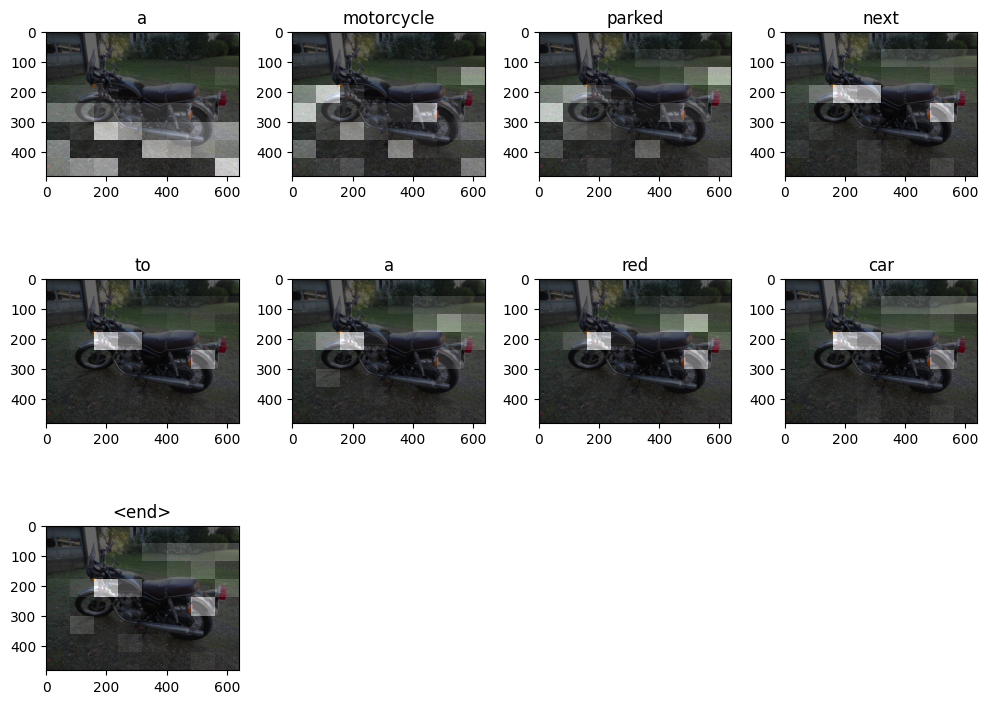

In [29]:
img_name, img_features, reltr_features, caption = val_dataset[0]
generated_caption, attention_plot = evaluate(torch.tensor(img_features), torch.tensor(reltr_features))

img = Image.open(img_name)
plt.title(' '.join(generated_caption))
plt.imshow(img)
print(' '.join(generated_caption))

def plot_attention(image, result, attention_plot):
    # temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

plot_attention(img, generated_caption, attention_plot)